In [1]:
from pydub import AudioSegment
import numpy as np
from scipy.fftpack import fft
import pydub
from scipy import signal
import array
import glob
import re
import pandas as pd
import librosa

In [2]:
def splitXSecond(x,overlap,path):
    audios=[]
    for file in glob.iglob(path):
        print(file)
        word=re.findall('[H,M]\w+',file)[0]
        audio=AudioSegment.from_file(file,format='wav')
        audio_arr=np.array(audio.get_array_of_samples()).astype("float32")
        chunks=librosa.effects.split(audio_arr, top_db=40, frame_length=2048, hop_length=512)
        for c in list(chunks):
            Fm=int((audio.frame_rate)/1000)
            length_audio=int((c[1]-c[0])/Fm)
            if length_audio>=x:
                for l in range(0,length_audio,overlap):
                    if max(audio_arr[l*Fm:(l+x)*Fm])>62:
                        a={}
                        a['name']=word[1:]
                        a['gender']=word[0]
                        silence_filter = array.array('h')
                        silence_filter.fromlist(list(map(int,audio_arr[l*Fm:(l+x)*Fm])))
                        a['1SecArray']=silence_filter
                        audios.append(a)
    return audios

In [4]:
path="./input_processed/*"
a=splitXSecond(1000,500,path)

./input_processed/HAlfonsoPastor.wav
./input_processed/HJoaquinPerez.wav
./input_processed/HJuanmaCruz.wav
./input_processed/HAlvaroRivas.wav
./input_processed/HMarioBru.wav
./input_processed/MSeoRa.wav
./input_processed/MCeliaPrieto.wav
./input_processed/HJorgeLopezMingo.wav
./input_processed/HAlbertoVargas.wav
./input_processed/MBegoEchavarren.wav
./input_processed/MCristinaRota.wav
./input_processed/HCesarCastares.wav
./input_processed/HToniPons.wav
./input_processed/MMariaVerdejo.wav


In [5]:
dfAudio=pd.DataFrame(a)
dfAudio

,name,gender,1SecArray
0,AlfonsoPastor,H,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0,..."
1,AlfonsoPastor,H,"[4, 8, 9, 7, 4, 0, 1, 3, 4, 1, -9, -23, -36, -..."
2,AlfonsoPastor,H,"[-79, -110, -132, -162, -209, -268, -322, -353..."
3,AlfonsoPastor,H,"[98, 132, 174, 221, 266, 298, 313, 308, 290, 2..."
4,AlfonsoPastor,H,"[286, 269, 247, 210, 161, 107, 53, -1, -62, -1..."
...,...,...,...
696,MariaVerdejo,M,"[-102, -254, -363, -423, -443, -428, -387, -31..."
697,MariaVerdejo,M,"[4252, 4496, 4657, 4727, 4704, 4599, 4431, 423..."
698,MariaVerdejo,M,"[4047, 4019, 3962, 3898, 3838, 3784, 3724, 364..."
699,MariaVerdejo,M,"[-425, -453, -472, -479, -476, -464, -442, -40..."


In [6]:
a=dfAudio.iloc[0,2]
audio=AudioSegment.from_file('./input_processed/HAlfonsoPastor.wav',format='wav')
audio._spawn(data=a)


In [7]:
len(dfAudio['1SecArray'][0])

48000

In [8]:
def fftransform(array):
    return np.abs(fft(array,512))
    #np.log

In [9]:
dfAudio['fft']=dfAudio['1SecArray'].apply(lambda x: fftransform(x))

In [10]:
def mfccTransform(arr):
    mfc=librosa.feature.mfcc(y=np.array(arr).astype('float64'),sr=48000,n_mfcc=256)
    return np.mean(mfc,axis=1)

In [11]:
dfAudio['mfcc']=dfAudio['1SecArray'].apply(lambda x: mfccTransform(x))

In [12]:
mfc=librosa.feature.mfcc(y=np.array(dfAudio['1SecArray'][0]).astype('float64'),sr=48000,n_mfcc=256)
mfcc_arr=np.mean(mfc,axis=1)

In [13]:
dfAudio

,name,gender,1SecArray,fft,mfcc
0,AlfonsoPastor,H,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0,...","[24.0, 16.502995218109124, 13.305133900431889,...","[313.88202, 109.57803, -55.15785, 6.8092365, 1..."
1,AlfonsoPastor,H,"[4, 8, 9, 7, 4, 0, 1, 3, 4, 1, -9, -23, -36, -...","[214.0, 207.0196087815407, 600.8169467393222, ...","[550.1415, 193.69284, -81.901215, 3.6269996, 1..."
2,AlfonsoPastor,H,"[-79, -110, -132, -162, -209, -268, -322, -353...","[2129.0, 2437.730989019643, 3767.9500811584826...","[576.9196, 206.22661, -80.48922, -0.60507554, ..."
3,AlfonsoPastor,H,"[98, 132, 174, 221, 266, 298, 313, 308, 290, 2...","[14161.0, 12034.665835604826, 22891.5796562430...","[554.2385, 199.73674, -71.5252, -4.0512285, 12..."
4,AlfonsoPastor,H,"[286, 269, 247, 210, 161, 107, 53, -1, -62, -1...","[5036.0, 6712.520432176193, 9997.385504476737,...","[517.3569, 219.9205, -73.41957, -6.630714, 15...."
...,...,...,...,...,...
696,MariaVerdejo,M,"[-102, -254, -363, -423, -443, -428, -387, -31...","[15020.0, 15086.329414460573, 9129.41633847465...","[649.0922, 192.29527, -67.119896, -49.954544, ..."
697,MariaVerdejo,M,"[4252, 4496, 4657, 4727, 4704, 4599, 4431, 423...","[50973.0, 53392.45142629805, 58386.90467348555...","[634.3273, 183.01723, -60.46327, -46.405968, -..."
698,MariaVerdejo,M,"[4047, 4019, 3962, 3898, 3838, 3784, 3724, 364...","[12419.0, 12732.039291355999, 15920.2538455810...","[596.54767, 183.74028, -68.6948, -33.076023, -..."
699,MariaVerdejo,M,"[-425, -453, -472, -479, -476, -464, -442, -40...","[3875.0, 4102.808248475922, 4833.761590564345,...","[552.2433, 237.91919, -124.89992, -6.78395, -9..."


In [40]:
#dfAudio['fft+mfcc']=np.concatenate((np.array(dfAudio['fft']),np.array(dfAudio['mfcc']).T))

#x=np.asarray(dfAudio['fft'][0])
dfAudio['fft+mfcc']=list(map(lambda x,y: np.concatenate((np.array(x),np.array(y))),dfAudio['fft'],dfAudio['mfcc']))
                             
                             

In [41]:
dfAudio

,name,gender,1SecArray,fft,mfcc,fft+mfcc
0,AlfonsoPastor,H,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, -1, 0,...","[24.0, 16.502995218109124, 13.305133900431889,...","[313.88202, 109.57803, -55.15785, 6.8092365, 1...","[24.0, 16.502995218109124, 13.305133900431889,..."
1,AlfonsoPastor,H,"[4, 8, 9, 7, 4, 0, 1, 3, 4, 1, -9, -23, -36, -...","[214.0, 207.0196087815407, 600.8169467393222, ...","[550.1415, 193.69284, -81.901215, 3.6269996, 1...","[214.0, 207.0196087815407, 600.8169467393222, ..."
2,AlfonsoPastor,H,"[-79, -110, -132, -162, -209, -268, -322, -353...","[2129.0, 2437.730989019643, 3767.9500811584826...","[576.9196, 206.22661, -80.48922, -0.60507554, ...","[2129.0, 2437.730989019643, 3767.9500811584826..."
3,AlfonsoPastor,H,"[98, 132, 174, 221, 266, 298, 313, 308, 290, 2...","[14161.0, 12034.665835604826, 22891.5796562430...","[554.2385, 199.73674, -71.5252, -4.0512285, 12...","[14161.0, 12034.665835604826, 22891.5796562430..."
4,AlfonsoPastor,H,"[286, 269, 247, 210, 161, 107, 53, -1, -62, -1...","[5036.0, 6712.520432176193, 9997.385504476737,...","[517.3569, 219.9205, -73.41957, -6.630714, 15....","[5036.0, 6712.520432176193, 9997.385504476737,..."
...,...,...,...,...,...,...
696,MariaVerdejo,M,"[-102, -254, -363, -423, -443, -428, -387, -31...","[15020.0, 15086.329414460573, 9129.41633847465...","[649.0922, 192.29527, -67.119896, -49.954544, ...","[15020.0, 15086.329414460573, 9129.41633847465..."
697,MariaVerdejo,M,"[4252, 4496, 4657, 4727, 4704, 4599, 4431, 423...","[50973.0, 53392.45142629805, 58386.90467348555...","[634.3273, 183.01723, -60.46327, -46.405968, -...","[50973.0, 53392.45142629805, 58386.90467348555..."
698,MariaVerdejo,M,"[4047, 4019, 3962, 3898, 3838, 3784, 3724, 364...","[12419.0, 12732.039291355999, 15920.2538455810...","[596.54767, 183.74028, -68.6948, -33.076023, -...","[12419.0, 12732.039291355999, 15920.2538455810..."
699,MariaVerdejo,M,"[-425, -453, -472, -479, -476, -464, -442, -40...","[3875.0, 4102.808248475922, 4833.761590564345,...","[552.2433, 237.91919, -124.89992, -6.78395, -9...","[3875.0, 4102.808248475922, 4833.761590564345,..."


In [44]:
type(np.asarray(dfAudio['fft'][0]))

numpy.ndarray

In [19]:
from scipy.fftpack import fft
import numpy as np
import matplotlib.pyplot as plt
F=48000
mod_FFT = np.abs(fft(dfAudio['1SecArray'][0],512))
print(mod_FFT)
print(len(mod_FFT)//2)
mod_FFT = mod_FFT[0:len(mod_FFT)//2]

x = np.arange(0,F,F/len(mod_FFT))

#plt.stem(mod_FFT)
#print(x[7],1/x[7]/3600,mod_FFT[2])

[ 5.         14.75007821  4.47682298 12.26517264 16.74230905  2.41863634
  4.14028045  7.17419402 17.75238177 12.4666936  11.43149837 12.58222562
 18.06768224 16.68483143  4.74091943 15.52708743 11.19803581  4.31837506
 11.0366534  19.96163225  8.69222614 11.98184991 10.95708191  3.26673483
 14.17771094  4.68501597  9.75108985  7.57122349  9.63617824 13.70573931
  9.91764518 13.85000339  2.18869166 11.87426504 10.99134651 13.90120065
 10.31656793  4.68046228  6.75687364  7.82463055  6.41038568  1.32795614
 12.36462357 13.74891831  2.35614167 10.77979294  9.04264864 25.05573775
  6.91163986  6.34370607 13.68499838 11.04584674  6.86861616  9.70077987
  5.67795803  9.12602619  4.25129717  8.09811953 13.16872075  6.23642247
  9.76281573  6.52765179 15.20529936  6.41660679  7.05302531 14.04881926
  8.60343927 10.18631676 16.95748308  8.56542412 16.16325437  1.63085807
  1.4589338  11.61319562  5.6568388   0.41780327  2.05701776  4.76607342
 13.58134531  9.56405869  9.79037189  8.864253    1

In [19]:
mod_FFT.shape

(24000,)

CouldntDecodeError: Couldn't find fmt header in wav data

In [2]:
audio = AudioSegment.from_file("input/HAlbertoVargas_new.wav",format='ogg')
audio_arr=audio.get_array_of_samples()
len(audio_arr)
audio

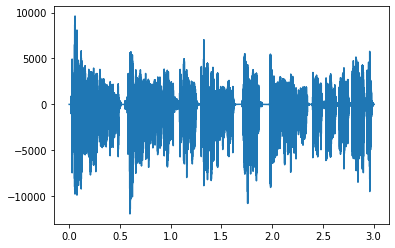

In [3]:
y=audio_arr
Fm = len(y)+1
total_seconds = 3
x = np.arange(0,total_seconds-total_seconds/Fm,total_seconds/Fm)
f_osc = 1
plt.plot(x,y)

In [6]:
import librosa
audio_arr=np.array(audio_arr)
audio_arr=audio_arr.astype("float32")
ys=librosa.effects.split(audio_arr, top_db=50, frame_length=2048, hop_length=512)

In [7]:
ys

array([[   9728,  285184],
       [ 307712,  312320],
       [ 313344,  598528],
       [ 601600,  712192],
       [ 720384,  914432],
       [ 950784, 1062912],
       [1100800, 1319424],
       [1333760, 1479168],
       [1480192, 1673176]])

In [37]:
for y in list(ys):
    silence_filter = array.array('h')
    silence_filter.fromlist(list(map(int,audio_arr[y[0]:y[1]])))
    audio_filtered=audio._spawn(data=silence_filter)
    display(audio_filtered)
    print(len(audio_filtered))
    i=0
    if len(audio_sil)>=1000:
        audio_filtered.export(f"./output/HAlbertoVargas{i}.wav", format="wav")
        i+=1

5739


96


5941


2304


4043


2336


4555


3029


4020


In [18]:
#audio.dBFS

-28.20561013920772

In [28]:
'''from pydub.silence import split_on_silence
chunks = split_on_silence(audio, 
    # must be silent for at least half a second
    min_silence_len=500,
    # consider it silent if quieter than -16 dBFS
    silence_thresh=audio.dBFS-16,keep_silence = 0
 )'''

In [29]:
len(chunks)

8

In [33]:
for c in chunks:
    display(c)